In [1]:
import motionmapperpy as mmpy
from scipy.signal import cwt, ricker
import wavelet as wl
from src.data_factory.processing import *
from src.utils import *
from src.config import BLOCK, ROOT_LOCAL
from src.metrics.tank_area_config import *
%matplotlib inline
import matplotlib.pyplot as plt
parameters = mmpy.setRunParameters()
parameters.pcaModes = 3
parameters.samplingFreq = 5
parameters.maxF = 2.5
parameters.minF = 0.01
parameters.omega0 = 5
parameters.projectPath = projectPath
parameters.training_points_of_day = 200
parameters.numProcessors = 16
parameters.method="UMAP"#"TSNE"
parameters.useGPU=0
parameters.training_numPoints = 3000    #% Number of points in mini-trainings.
parameters.trainingSetSize = 5000  #% Total number of training set points to find. 
                                 #% Increase or decrease based on
                                 #% available RAM. For reference, 36k is a 
                                 #% good number with 64GB RAM.

%load_ext autoreload
%autoreload 2 

In [2]:
#parameters

In [15]:
parameters.useGPU=0
import cupy as cp
x = cp.array([1, 2, 3])
print(x.device)

<CUDA Device 0>


In [2]:
# This creates a project directory structure which will be used to store all motionmappery pipeline
# related data in one place.
os.makedirs(parameters.projectPath,exist_ok=True)
mmpy.createProjectDirectory(parameters.projectPath)

Skipping, path already exists : content/Fish_moves
Skipping, path already exists : content/Fish_moves/Projections
Skipping, path already exists : content/Fish_moves/TSNE_Projections
Skipping, path already exists : content/Fish_moves/TSNE
Skipping, path already exists : content/Fish_moves/UMAP


In [2]:
fish_keys = get_camera_pos_keys()
area_f = get_area_functions()
days = get_all_days_of_context()
fk = fish_keys[1]
day = days[6]
area_t = (fk, area_f(fk,day))
 
#X = compute_projections(fk, day, area_t)
#X.shape

In [ ]:
compute_all_projections(fish_keys, recompute=True)

23442333_back 0 20210911_060000 0 (143592, 6)
23442333_back 0 20210912_060000 1 (143592, 6)
23442333_back 0 20210913_060000 2 (143594, 6)
23442333_back 0 20210914_060000 3 (143568, 6)
23442333_back 0 20210915_060000 4 (143590, 6)
23442333_back 0 20210916_060000 5 (143590, 6)
23442333_back 0 20210917_060000 6 (143590, 6)
23442333_back for day 20210918_060000 is empty! 
23442333_back for day 20210919_060000 is empty! 
23442333_back for day 20210920_060000 is empty! 
23442333_back for day 20210921_060000 is empty! 
23442333_back for day 20210922_060000 is empty! 
23442333_back for day 20210923_060000 is empty! 
23442333_back for day 20210924_060000 is empty! 
23442333_back for day 20210925_060000 is empty! 
23442333_back 0 20210926_060000 15 (143358, 6)
23442333_back 0 20210927_060000 16 (142898, 6)
AREA: 23442333_back,  10000 dataframes out of 143652 where on the other side of the tank. They are beeing filtered out.
23442333_back 0 20210928_060000 17 (133160, 6)
23442333_back 0 20210929_

In [ ]:
mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)

Text(0.5, 0, 'Frames')

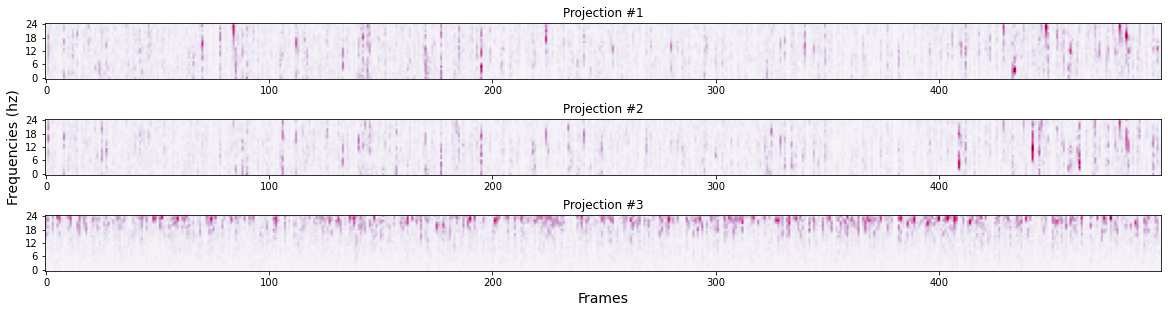

In [18]:
fig, axes = plt.subplots(parameters.pcaModes, 1, figsize=(20,5))

for i, ax in enumerate(axes.flatten()):
    nper = parameters.numPeriods
    ax.imshow(sample_wlets[:500,nper*i:nper*(i+1)].T.get(), cmap='PuRd', origin='lower')
    yticks = range(0, nper, 6)
    ax.set_yticks(yticks)
    #ax.set_yticklabels(['%0.1f'%freqs[j] for j in yticks])
    if i == parameters.pcaModes//2:
        ax.set_ylabel("Frequencies (hz)", fontsize=14)
    ax.set_title('Projection #%i'%(i+1))
ax.set_xlabel('Frames', fontsize=14)


In [45]:
#X_em = mmpy.run_UMAP(sample_wlets.get(),parameters)

In [3]:
trainy = hdf5storage.loadmat('%s/%s/training_embedding.mat'%(parameters.projectPath, parameters.method))['trainingEmbedding']

FileNotFoundError: [Errno 2] No such file or directory: 'content/Fish_moves/UMAP/training_embedding.mat'

In [ ]:
#trainy = X_em
m = np.abs(trainy).max()
sigma=2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-20, m+20])

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=np.arange(trainy.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])
axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

In [9]:
#mmpy.wshed.findWatershedRegions(parameters, minimum_regions=7, endident=f"{BLOCK}*.npy")

In [27]:
#tsne takes 19 mins
import time
tall = time.time()

import h5py, hdf5storage, pickle, glob
tfolder = parameters.projectPath+'/%s/'%parameters.method

# Loading training data
with h5py.File(tfolder + 'training_data.mat', 'r') as hfile:
    trainingSetData = hfile['trainingSetData'][:].T

# Loading training embedding
with h5py.File(tfolder+ 'training_embedding.mat', 'r') as hfile:
    trainingEmbedding= hfile['trainingEmbedding'][:].T

if parameters.method == 'TSNE':
    zValstr = 'zVals' 
else:
    zValstr = 'uVals'

projectionFiles = glob.glob(parameters.projectPath+'/Projections/*pcaModes.mat')
for i in range(len(projectionFiles)):
    print('Finding Embeddings')
    t1 = time.time()
    print('%i/%i : %s'%(i+1,len(projectionFiles), projectionFiles[i]))

    # Skip if embeddings already found.
    if os.path.exists(projectionFiles[i][:-4] +'_%s.mat'%(zValstr)):
        print('Already done. Skipping.\n')
        continue

    # load projections for a dataset
    projections = hdf5storage.loadmat(projectionFiles[i])['projections']
    print(projections.shape, trainingSetData.shape)
    # Find Embeddings
    zValues, outputStatistics = mmpy.findEmbeddings(projections,trainingSetData,trainingEmbedding,parameters)

    # Save embeddings
    hdf5storage.write(data = {'zValues':zValues}, path = '/', truncate_existing = True,
                    filename = projectionFiles[i][:-4]+'_%s.mat'%(zValstr), store_python_metadata = False,
                    matlab_compatible = True)
    
    # Save output statistics
    with open(projectionFiles[i][:-4] + '_%s_outputStatistics.pkl'%(zValstr), 'wb') as hfile:
        pickle.dump(outputStatistics, hfile)

    del zValues,projections,outputStatistics

print('All Embeddings Saved in %i seconds!'%(time.time()-tall))


Finding Embeddings
1/3 : content/Fish_moves/Projections/block1_23484204_back_20210911_060000_pcaModes.mat
Already done. Skipping.

Finding Embeddings
2/3 : content/Fish_moves/Projections/block1_23484204_back_20210912_060000_pcaModes.mat
Already done. Skipping.

Finding Embeddings
3/3 : content/Fish_moves/Projections/block1_23484204_back_20210927_060000_pcaModes.mat
Already done. Skipping.

All Embeddings Saved in 0 seconds!


In [6]:
if parameters.method == 'TSNE':
    zValstr = 'zVals'
else:
    zValstr = 'uVals'

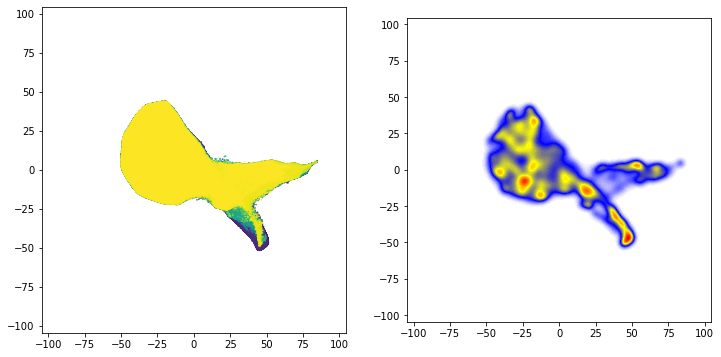

In [7]:
# load all the embeddings
list_ally = []
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
    list_ally.append(hdf5storage.loadmat(i)['zValues'])
ally = np.concatenate(list_ally)
m = np.abs(ally).max()

sigma=2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(ally[:,0], ally[:,1], marker='.', c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

1/55 Loading embedding for block1_23484204_back_20211007_060000_pcaModes 0.00 seconds.
2/55 Loading embedding for block1_23484201_back_20210912_060000_pcaModes 0.02 seconds.
3/55 Loading embedding for block1_23484201_back_20210913_060000_pcaModes 0.03 seconds.
4/55 Loading embedding for block1_23484201_back_20210914_060000_pcaModes 0.09 seconds.
5/55 Loading embedding for block1_23484201_back_20210915_060000_pcaModes 0.11 seconds.
6/55 Loading embedding for block1_23484201_back_20210916_060000_pcaModes 0.12 seconds.
7/55 Loading embedding for block1_23484201_back_20210917_060000_pcaModes 0.13 seconds.
8/55 Loading embedding for block1_23484201_back_20210918_060000_pcaModes 0.14 seconds.
9/55 Loading embedding for block1_23484201_back_20210919_060000_pcaModes 0.18 seconds.
10/55 Loading embedding for block1_23484201_back_20210920_060000_pcaModes 0.19 seconds.
11/55 Loading embedding for block1_23484201_back_20210921_060000_pcaModes 0.21 seconds.
12/55 Loading embedding for block1_234842

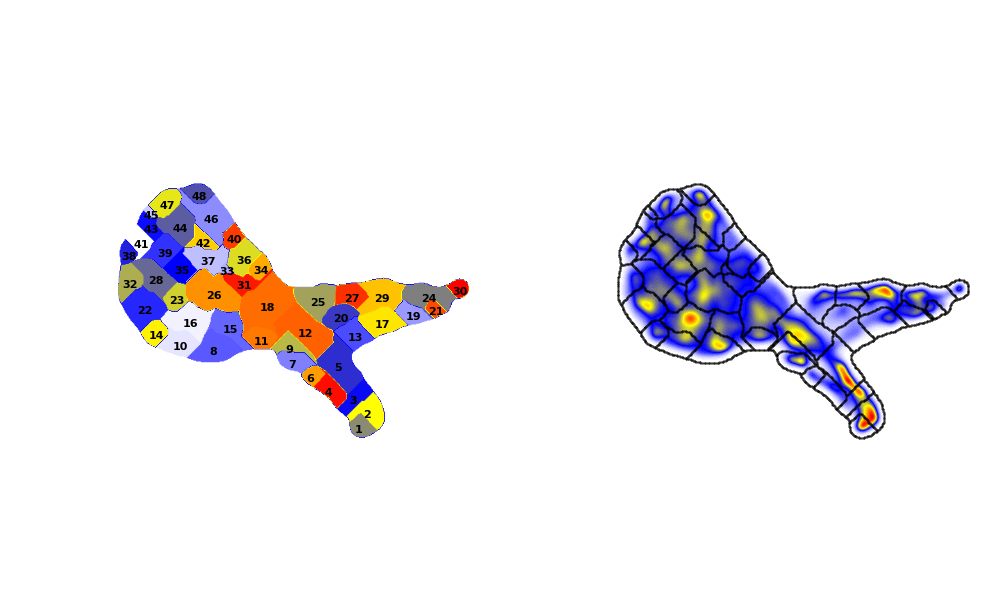

In [39]:
startsigma = 4.2 if parameters.method == 'TSNE' else 1.0
mmpy.findWatershedRegions(parameters, minimum_regions=5, startsigma=startsigma, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = '*_pcaModes.mat')

from IPython.display import Image
Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

In [36]:
wshedfile["watershedRegions"].shape, wshedfile['zValues'].shape

((1, 7871952), (7871952, 2))

In [35]:
7871952/3864834

2.036815035264128

(2000000, 6)
(2000000, 6)


Text(0.5, 0, 'Time (min)')

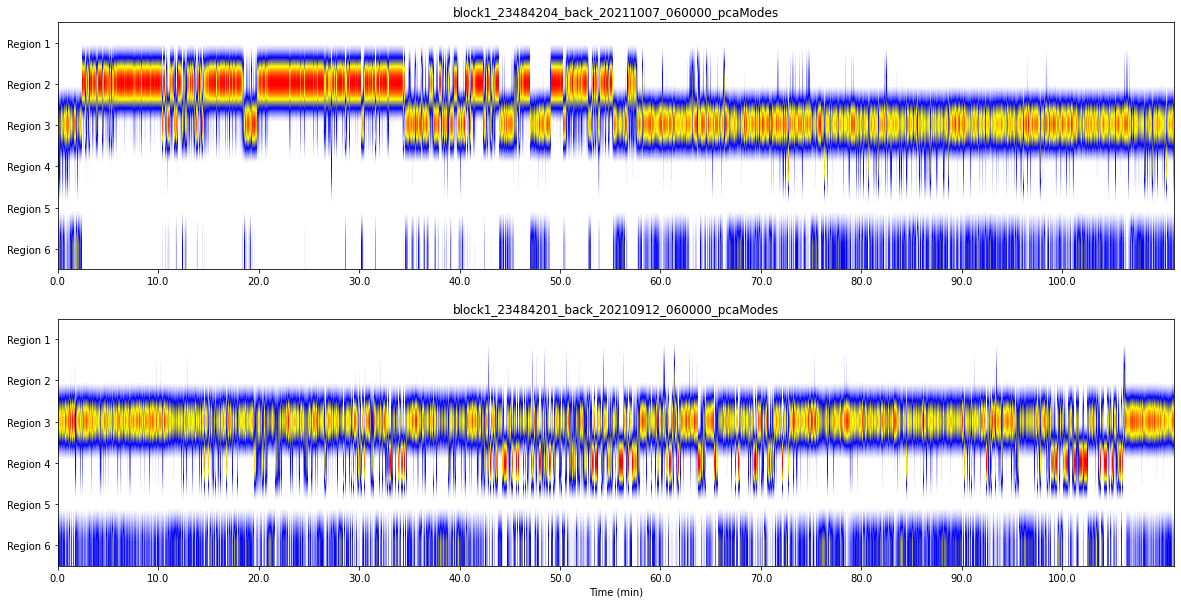

In [41]:
wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

offset = 100000
len_s = 4000000
len_half = len_s//2
wregs = wshedfile['watershedRegions'].flatten()[offset:offset+len_s]
ethogram = np.zeros((wregs.max()+1, len(wregs)))

for wreg in range(1, wregs.max()+1):
    ethogram[wreg, np.where(wregs==wreg)[0]] = 1.0


ethogram = np.split(ethogram.T, np.cumsum(
    #wshedfile['zValLens'][0].flatten()
[len_half,len_half])[:-1])

fig, axes = plt.subplots(2, 1, figsize=(20,10))

for e, name, ax in zip(ethogram, wshedfile['zValNames'][0], axes.flatten()):
    print(e.shape)
    ax.imshow(e.T, aspect='auto', cmap=mmpy.gencmap())
    ax.set_title(name[0][0])
    ax.set_yticks([i for i in range(0, wregs.max()+1, 1)])
    ax.set_yticklabels(['Region %i'%(j+1) for j in range(0, wregs.max()+1, 1)])

    xticklocs = [10*(60**2)*5*i for i in range(len_half//((60**2)*5*10))]
    ax.set_xticks(xticklocs)
    ax.set_xticklabels([j/((60**2)*5) for j in xticklocs])

ax.set_xlabel('Time (min)')

In [18]:
# Python standard library packages to do file/folder manipulations,
# pickle is a package to store python variables
import glob, os, pickle, sys

# time grabs current clock time and copy to safely make copies of large 
# variables in memory.
import time, copy 

# datetime package is used to get and manipulate date and time data
from datetime import datetime

# this packages helps load and save .mat files older than v7
import hdf5storage, h5py

# numpy works with arrays, pandas used to work with fancy numpy arrays
import numpy as np
import pandas as pd

# matplotlib is used to plot and animate to make movies
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# moviepy helps open the video files in Python
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Scikit-learn is a go-to library in Python for all things machine learning
from sklearn.decomposition import PCA

# tqdm helps create progress bars in for loops 
from tqdm import tqdm 

# Scipy is a go-to scientific computing library. We'll use it for median filtering. 
from scipy.ndimage import median_filter

# Configuring matplotlib to show animations in a colab notebook as javascript 
# objects for easier viewing. 
from matplotlib import rc
rc('animation', html='jshtml')

In [42]:
#wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

try:
    tqdm._instances.clear()
except:
    pass

#data 
day_idx = 22
zValues = fk_X_zVals[day_idx]['zValues']
traj_data = fk_X[day_idx]['positions']
area_box = fk_X[day_idx]['area']

fig, axes = plt.subplots(1, 2, figsize=(10,5))
#tfolder = parameters.projectPath+'/%s/'%parameters.method
#with h5py.File(tfolder + 'training_embedding.mat', 'r') as hfile:
#    trainingEmbedding = hfile['trainingEmbedding'][:].T
#    trainingEmbedding = np.concatenate([trainingEmbedding,zValues[:len(trainingEmbedding)]])
trainingEmbedding = np.concatenate([fk_zV['zValues'] for fk_zV in fk_X_zVals])
print("trainingEmbedding: ", trainingEmbedding.shape)
m = np.abs(trainingEmbedding).max()


sigma=1.0
_, xx, density = mmpy.findPointDensity(trainingEmbedding, sigma, 511, [-m-10, m+10])
axes[0].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
axes[0].axis('off')
axes[0].set_title('Method : %s'%parameters.method)
sc = axes[0].scatter([],[],marker='o', color='k', s=300)

area_box = np.concatenate((area_box, [area_box[0]]))
axes[1].plot(*area_box.T)
(line,) = axes[1].plot([],[], "-o")

h5ind = 1
tstart = 0

def animate(t):
    t = int(t*50)+tstart
    line.set_data(*traj_data[20000*h5ind+t-50:20000*h5ind+t+50].T)
    axes[1].axis('off')
    sc.set_offsets(zValues[20000*h5ind+t])
    return mplfig_to_npimage(fig) #im, ax


anim = VideoClip(animate, duration=20) # will throw memory error for more than 100.
plt.close()
anim.ipython_display(fps=20, loop=True, autoplay=True, maxduration=120)


trainingEmbedding:  (3864834, 2)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [13]:
fk_X = load_trajectory_data(fish_keys[1], parameters)

In [14]:
fk_X_zVals = load_zVals(fish_keys[1], parameters)

In [20]:
len(fk_X_zVals)

27

In [16]:
len(fk_X)

27

In [36]:
zValues_list = []
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
    zValues_list.append(hdf5storage.loadmat(i)['zValues'])
zValues_concat = np.concatenate(zValues_list)

In [38]:
zValues_concat.shape

(430489, 2)